# Trainig Deep Models

In [145]:
import os

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

## 1. Configurations

In [146]:
RAW_BASE_DIR = "C:/Others/Mahsa-UoR/Project/wisdm-dataset/raw/"
RAW_COL_NAMES = ["SubjectID", "ActivityCode", "Timestamp", "X", "Y", "Z"]
PROCESS_BASE_DIR = "C:/Others/Mahsa-UoR/Project/wisdm-dataset/processed"
ACTIVITIES_MAP = {"A": "Walking","B": "Jogging","C": "Stairs","D": "Sitting","E": "Standing"}

TRAIN_COLUMNS = ["X_std", "Y_std", "Z_std"]
TEST_SIZE = 0.33
VAL_SIZE = 0.20
LABELS_LEN = len(ACTIVITIES_MAP)
EPOCH = 50
BATCH_SIZE = 64
FRAME_SIZE = 100
TIME_STEP = 40
METRICS = [keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]

### 1.2 Plot Functions

In [147]:
def ploat_learning_cruve(history):
    fig, ax = plt.subplots(1,2, figsize=(15, 3))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    ax[0].plot(epochs, loss, "bo", label="Training loss")
    ax[0].plot(epochs, val_loss, "b", label="Validation loss")
    ax[0].set_title(f"Training and validation loss Watch Accelerometer")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(loc='upper left')
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    ax[1].plot(epochs, acc, "bo", label="Training accuracy")
    ax[1].plot(epochs, val_acc, "b", label="Validation accuracy")
    ax[1].set_title(f"Training and validation accuracy Watch Accelerometer")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend(loc='upper left')
    plt.show()

def plot_confusion_matrix(test_data, test_labels, test_labels_prediction):
    cm = confusion_matrix(test_labels.argmax(axis=1), test_labels_prediction.argmax(axis=1) , normalize='pred')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+list(ACTIVITIES_MAP.values()))
    ax.set_yticklabels(['']+list(ACTIVITIES_MAP.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## 2. Load Input

In [148]:
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    df["ActivityCode"] = df["ActivityCode"].astype('string')
    df["X"] = df["X"].astype('float32')
    df["Y"] = df["Y"].astype('float32')
    df["Z"] = df["Z"].apply(lambda x: x.replace(';', '')).astype('float32')
    return df

In [149]:
watch_accel = load_and_clean_csv(os.path.join(PROCESS_BASE_DIR, "watch_accel.csv"))
watch_accel = watch_accel[watch_accel["ActivityCode"].isin(ACTIVITIES_MAP)]
watch_accel.head()

,SubjectID,ActivityCode,Timestamp,X,Y,Z
0,1600,A,90426708196641,7.091625,-0.591667,8.195502
1,1600,A,90426757696641,4.972757,-0.158317,6.696732
2,1600,A,90426807196641,3.253720,-0.191835,6.107758
3,1600,A,90426856696641,2.801216,-0.155922,5.997625
4,1600,A,90426906196641,3.770868,-1.051354,7.731027


# 3. Transform

## 3.1 Label Endoder

In [150]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(list(ACTIVITIES_MAP))

watch_accel["ActivityCode"] = label_encoder.transform(watch_accel["ActivityCode"])

## 3.1 Standard Scalar

In [151]:
std_scaler = preprocessing.StandardScaler()

watch_accel[["X_std", "Y_std", "Z_std"]] = std_scaler.fit_transform(watch_accel[["X", "Y", "Z"]])

array([<AxesSubplot:title={'center':'X_std'}>,
       <AxesSubplot:title={'center':'Y_std'}>,
       <AxesSubplot:title={'center':'Z_std'}>], dtype=object)

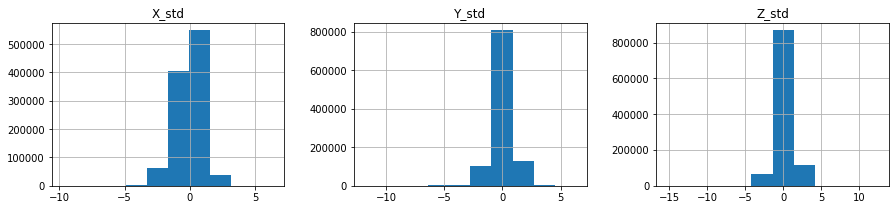

In [152]:
fig, ax = plt.subplots(1,3, figsize=(15, 3))
watch_accel[["X_std", "Y_std", "Z_std"]].hist(ax= ax)

## 4 Deep Models

### 4.1 Dense

In [10]:
def split_data_dense(df, label_name = "ActivityCode", test_size=0.33, train_columns = TRAIN_COLUMNS ):
    X_train_val, X_test, y_train_val, y_test = train_test_split(df, df[label_name], test_size=TEST_SIZE, random_state=42, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VAL_SIZE, random_state=42, shuffle=True)
    y_train, y_test, y_val = to_categorical(y_train), to_categorical(y_test), to_categorical(y_val)
    return (X_train[train_columns], y_train), (X_test[train_columns], y_test), (X_val[train_columns], y_val)

In [11]:
(train_data, train_labels),(test_data, test_labels),(val_data, val_labels)= split_data_dense(watch_accel)

In [12]:
print(f"Inputs: Train: {train_data.shape}, Validation: {val_data.shape}, Test: {test_data.shape}")
print(f"Labels: Train: {train_labels.shape}, Validation: {val_labels.shape}, Test: {test_labels.shape}")

Inputs: Train: (564483, 3), Validation: (141121, 3), Test: (347537, 3)
Labels: Train: (564483, 5), Validation: (141121, 5), Test: (347537, 5)


#### 4.1.1 Build Dense Model

In [13]:
dense_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape = (3, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(LABELS_LEN, activation="softmax")
])
dense_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics= METRICS)
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4,741
Trainable params: 4,741
Non-trainable params: 0
_________________________________________________________________


#### 4.1.2 Train Dense Model

In [29]:
dense_history = dense_model.fit(
                    train_data,
                    train_labels,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_data, val_labels))

Epoch 1/50
8821/8821 [==============================] - 9s 1ms/step - loss: 0.7515 - accuracy: 3.8761e-04 - precision: 0.7712 - recall: 0.5998 - auc: 0.9286 - val_loss: 0.7594 - val_accuracy: 5.3429e-04 - val_precision: 0.7658 - val_recall: 0.6020 - val_auc: 0.9273
Epoch 2/50
8821/8821 [==============================] - 14s 2ms/step - loss: 0.7520 - accuracy: 4.0391e-04 - precision: 0.7710 - recall: 0.5996 - auc: 0.9285 - val_loss: 0.7566 - val_accuracy: 5.4421e-04 - val_precision: 0.7751 - val_recall: 0.5958 - val_auc: 0.9280
Epoch 3/50
8821/8821 [==============================] - 14s 2ms/step - loss: 0.7522 - accuracy: 4.5316e-04 - precision: 0.7713 - recall: 0.6000 - auc: 0.9285 - val_loss: 0.7859 - val_accuracy: 4.1666e-04 - val_precision: 0.7462 - val_recall: 0.6057 - val_auc: 0.9227
Epoch 4/50
8821/8821 [==============================] - 12s 1ms/step - loss: 0.7529 - accuracy: 4.9284e-04 - precision: 0.7711 - recall: 0.6003 - auc: 0.9284 - val_loss: 0.7740 - val_accuracy: 6.5192e

8821/8821 [==============================] - 13s 1ms/step - loss: 0.7701 - accuracy: 0.0035 - precision: 0.7670 - recall: 0.5973 - auc: 0.9264 - val_loss: 0.7869 - val_accuracy: 0.0031 - val_precision: 0.7607 - val_recall: 0.5990 - val_auc: 0.9229
Epoch 33/50
8821/8821 [==============================] - 11s 1ms/step - loss: 0.7699 - accuracy: 0.0037 - precision: 0.7671 - recall: 0.5976 - auc: 0.9265 - val_loss: 0.7794 - val_accuracy: 0.0043 - val_precision: 0.7562 - val_recall: 0.6092 - val_auc: 0.9253
Epoch 34/50
8821/8821 [==============================] - 10s 1ms/step - loss: 0.7699 - accuracy: 0.0040 - precision: 0.7676 - recall: 0.5971 - auc: 0.9264 - val_loss: 0.8296 - val_accuracy: 0.0048 - val_precision: 0.7288 - val_recall: 0.5899 - val_auc: 0.9150
Epoch 35/50
8821/8821 [==============================] - 10s 1ms/step - loss: 0.7710 - accuracy: 0.0042 - precision: 0.7669 - recall: 0.5965 - auc: 0.9264 - val_loss: 0.7785 - val_accuracy: 0.0045 - val_precision: 0.7587 - val_recal

#### 4.1.3 Evaulate Dense Model

In [30]:
score = dense_model.evaluate(test_data, test_labels, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

10861/10861 [==============================] - 16s 1ms/step - loss: 0.7944 - accuracy: 0.0047 - precision: 0.7549 - recall: 0.5955 - auc: 0.9236
Test loss: 0.7943500280380249 / Test accuracy: 0.004730431362986565


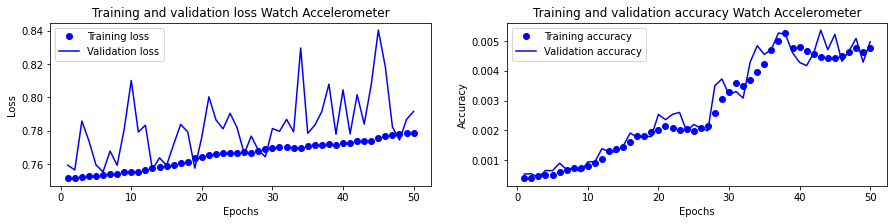

In [31]:
ploat_learning_cruve(dense_history)

10861/10861 [==============================] - 6s 554us/step


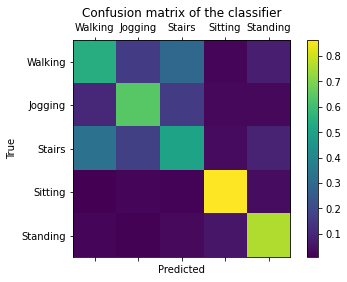

In [32]:
test_labels_prediction = dense_model.predict(test_data)
plot_confusion_matrix(test_data, test_labels, test_labels_prediction)

### 4.2 Conv2D

In [153]:
def split_data_by_frame(df, label_name = "ActivityCode", test_size=0.33, train_columns = ["X", "Y", "Z"], frame_size = 100, time_step = 40):
    X_list, y_list = [], []
    for i in range(0, len(df) - frame_size, time_step):
        x = df[train_columns[0]].values[i: i + frame_size]
        y = df[train_columns[1]].values[i: i + frame_size]
        z = df[train_columns[2]].values[i: i + frame_size]
        
        label = stats.mode(df[label_name][i: i + frame_size])[0][0]
        X_list.append([x, y, z])
        y_list.append(label)
    
    X_arr, y_arr = np.asarray(X_list, dtype=np.float32).reshape(-1, frame_size, len(train_columns), 1), np.array(y_list)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_arr, y_arr, test_size=0.33, random_state=42, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=True)
    y_train, y_test, y_val = to_categorical(y_train), to_categorical(y_test), to_categorical(y_val)
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)
    

In [127]:
(train_data_conv2d, train_labels_conv2d),(test_data_conv2d, test_labels_conv2d),(val_data_conv2d, val_labels_conv2d)= split_data_by_frame(watch_accel)

In [128]:
print(f"Inputs: Train: {train_data_conv2d.shape}, Validation: {val_data_conv2d.shape}, Test: {test_data_conv2d.shape}")
print(f"Labels: Train: {train_labels_conv2d.shape}, Validation: {val_labels_conv2d.shape}, Test: {test_labels_conv2d.shape}")

Inputs: Train: (14111, 100, 3, 1), Validation: (3528, 100, 3, 1), Test: (8688, 100, 3, 1)
Labels: Train: (14111, 5), Validation: (3528, 5), Test: (8688, 5)


#### 4.2.1 Build Conv2D Model

In [154]:
conv2d_model = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=2, input_shape=(100, 3, 1), activation='relu'),
    layers.Dropout(0.1),
    layers.Conv2D(filters=32, kernel_size=2, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(LABELS_LEN, activation='softmax')
])
conv2d_model.compile(optimizer=Adam(learning_rate = 0.001), loss="categorical_crossentropy", metrics= METRICS)
conv2d_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 99, 2, 16)         80        
                                                                 
 dropout_10 (Dropout)        (None, 99, 2, 16)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 98, 1, 32)         2080      
                                                                 
 dropout_11 (Dropout)        (None, 98, 1, 32)         0         
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_11 (Dense)            (None, 64)                200768    
                                                                 
 dropout_12 (Dropout)        (None, 64)               

#### 4.2.2 Train Conv2D Model

In [165]:
conv2d_model.compile(optimizer=Adam(learning_rate = 0.001), loss="categorical_crossentropy", metrics= ["accuracy"])
TRAIN_COLUMNS = ["X_std", "Y_std", "Z_std"]
conv2d_history = conv2d_model.fit(train_data_conv2d,
                    train_labels_conv2d,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_data_conv2d, val_labels_conv2d))

Epoch 1/50
221/221 [==============================] - 2s 8ms/step - loss: 4.3832 - accuracy: 0.6895 - val_loss: 0.6643 - val_accuracy: 0.8112
Epoch 2/50
221/221 [==============================] - 2s 8ms/step - loss: 0.5547 - accuracy: 0.7667 - val_loss: 0.5637 - val_accuracy: 0.8365
Epoch 3/50
221/221 [==============================] - 2s 7ms/step - loss: 0.4823 - accuracy: 0.7939 - val_loss: 0.6160 - val_accuracy: 0.8501
Epoch 4/50
221/221 [==============================] - 2s 8ms/step - loss: 0.4182 - accuracy: 0.8191 - val_loss: 0.5419 - val_accuracy: 0.8622
Epoch 5/50
221/221 [==============================] - 2s 10ms/step - loss: 0.3835 - accuracy: 0.8216 - val_loss: 0.6263 - val_accuracy: 0.8435
Epoch 6/50
221/221 [==============================] - 3s 15ms/step - loss: 0.3666 - accuracy: 0.8370 - val_loss: 0.5999 - val_accuracy: 0.8654
Epoch 7/50
221/221 [==============================] - 3s 13ms/step - loss: 0.3384 - accuracy: 0.8435 - val_loss: 0.5749 - val_accuracy: 0.8801
Epo

#### 4.2.3 Evaulate Conv2D Model

In [168]:
score = conv2d_model.evaluate(test_data_conv2d, test_labels_conv2d, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

272/272 [==============================] - 0s 1ms/step - loss: 0.4396 - accuracy: 0.8927
Test loss: 0.4396263062953949 / Test accuracy: 0.8927255868911743


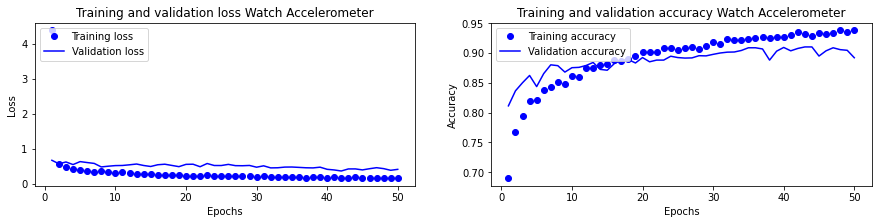

In [169]:
ploat_learning_cruve(conv2d_history)

272/272 [==============================] - 0s 1ms/step


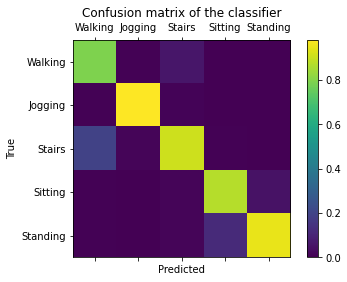

In [171]:
test_labels_prediction = conv2d_model.predict(test_data_conv2d)
plot_confusion_matrix(test_data_conv2d, test_labels_conv2d, test_labels_prediction)

### 4.3 LSTM

In [172]:
(train_data_lstm, train_labels_lstm),(test_data_lstm, test_labels_lstm),(val_data_lstm, val_labels_lstm)= split_data_by_frame(watch_accel)

In [173]:
print(f"Inputs: Train: {train_data_lstm.shape}, Validation: {val_data_lstm.shape}, Test: {test_data_lstm.shape}")
print(f"Labels: Train: {train_labels_lstm.shape}, Validation: {val_labels_lstm.shape}, Test: {test_labels_lstm.shape}")

Inputs: Train: (14111, 100, 3, 1), Validation: (3528, 100, 3, 1), Test: (8688, 100, 3, 1)
Labels: Train: (14111, 5), Validation: (3528, 5), Test: (8688, 5)


#### 4.3.1 Build LSTM Model

In [174]:
model_lstm = keras.Sequential([
    layers.LSTM(50, input_shape=(100, 3)),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu'),
    layers.Dense(LABELS_LEN, activation='softmax')
])
model_lstm.compile(optimizer=Adam(learning_rate = 0.001), loss="categorical_crossentropy", metrics= ["accuracy"])
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10800     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 5)                 255       
                                                                 
Total params: 13,605
Trainable params: 13,605
Non-trainable params: 0
_________________________________________________________________


#### 4.3.2 Train LSTM Model

In [175]:
model_lstm.compile(optimizer=Adam(learning_rate = 0.001), loss="categorical_crossentropy", metrics=["accuracy"])
TRAIN_COLUMNS = ["X_std", "Y_std", "Z_std"]
lstm_history = model_lstm.fit(train_data_lstm,
                    train_labels_lstm,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_data_lstm, val_labels_lstm))

Epoch 1/50
221/221 [==============================] - 10s 40ms/step - loss: 1.0907 - accuracy: 0.5416 - val_loss: 0.6777 - val_accuracy: 0.7109
Epoch 2/50
221/221 [==============================] - 11s 51ms/step - loss: 0.7198 - accuracy: 0.6834 - val_loss: 0.6753 - val_accuracy: 0.6868
Epoch 3/50
221/221 [==============================] - 12s 55ms/step - loss: 0.6532 - accuracy: 0.7040 - val_loss: 0.5859 - val_accuracy: 0.7355
Epoch 4/50
221/221 [==============================] - 11s 49ms/step - loss: 0.6116 - accuracy: 0.7208 - val_loss: 0.5672 - val_accuracy: 0.7506
Epoch 5/50
221/221 [==============================] - 12s 53ms/step - loss: 0.6086 - accuracy: 0.7247 - val_loss: 0.6678 - val_accuracy: 0.7069
Epoch 6/50
221/221 [==============================] - 12s 54ms/step - loss: 0.5920 - accuracy: 0.7334 - val_loss: 0.5552 - val_accuracy: 0.7429
Epoch 7/50
221/221 [==============================] - 11s 52ms/step - loss: 0.5595 - accuracy: 0.7531 - val_loss: 0.5299 - val_accuracy:

#### 4.3.3 Evaulate LSTM Model

In [ ]:
score = model_lstm.evaluate(test_data_lstm, test_labels_lstm, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
ploat_learning_cruve(lstm_history)

In [ ]:
test_labels_prediction = model_lstm.predict(test_data_lstm)
plot_confusion_matrix(test_data_lstm, test_labels_lstm, test_labels_prediction)